In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, mean_squared_error, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm 

from aiutils import classification_rate, load, save, softmax
from config import GameConfig
from enums import StartingSplit, FeatureType
from env import DefaultEnvironment, Environment
from mlp import PredictorMLP
from mlprunner import train_mlp
from player import load_players, RolloutPlayer
from predictor import sample_training_batch, test_mlp
from rollout import LogisticRegressionEnsembleRollout
from state import DecisionResponse, DecisionState, State, ReducedStateFeature
from supply import Supply

In [4]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [5]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

## Logistic Regression: Manual Weight Setting ##

We expect 100% classification accuracy on terminal states when the weights are equal to the VP value of the corresponding cards. 

In [6]:
dataset_name = 'test-bm-bm-1k-terminal'
data_path = os.path.join(project_root, 'datasets', dataset_name)

In [12]:
raw_data = load(data_path)
test_X_bm, test_y_bm = raw_data[0], raw_data[1]
X = test_X_bm
y = test_y_bm

# What are the class priors in the training sample? 
classes, rates = classification_rate(test_y_bm)
classes, rates

# Reduce three classes to two classes
train_y = test_y_bm.copy()
train_y[train_y < 0] = 0
class_map = {-1: 'loss', 0: 'tie', 1: 'win'}

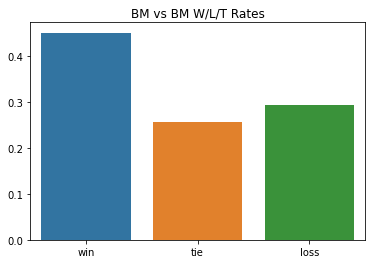

In [36]:
outcomes = [class_map[i] for i in classes]
fig = plt.figure()
ax = plt.axes()
sns.barplot(x=outcomes, y=rates)
ax.set_title('BM vs BM W/L/T Rates')
plt.show()

In [12]:
manual_weights = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  3.,  6.,  0.,
        0.,  0.,  1., -1., -3., -6.,  0.,  0.])

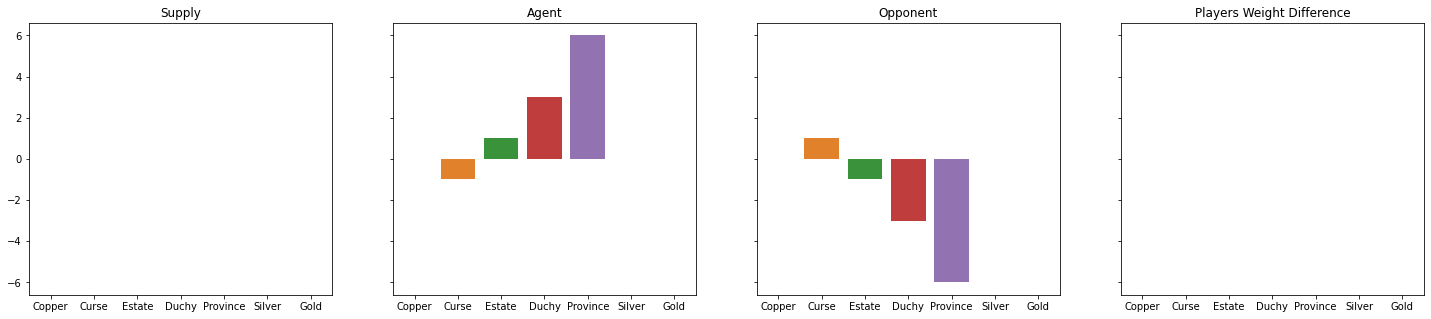

In [56]:
test_model = LogisticRegression()
test_model.coef_ = np.array([manual_weights])
test_model.intercept_ = 0
test_model.classes_ = np.array([0, 1])

agent_weights = test_model.coef_[0][7:14]
opp_weights = test_model.coef_[0][14:]
supply_weights = test_model.coef_[0][:7]
player_weight_diffs = agent_weights + opp_weights
cards = list(idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
axes[0].set_title('Supply')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
axes[1].set_title('Agent')
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
axes[2].set_title('Opponent')
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
axes[3].set_title('Players Weight Difference')
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])
plt.show()test_X_random

Acc: 1.0
AUC ROC: 1.0


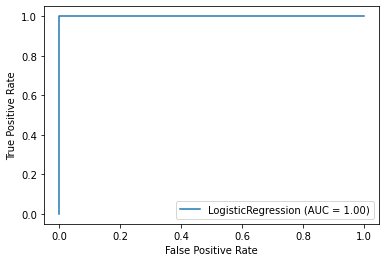

In [17]:
test_probs = test_model.predict_proba(X)[:, 1]
print(f'Acc: {test_model.score(X, train_y)}\nAUC ROC: {roc_auc_score(train_y, test_probs)}')
plot_roc_curve(test_model, X, train_y)

## Big Money Players Predicting Random Play Terminal State ##

In [15]:
model_name = 'bm-bm-logistic-pred-10k-terminal'
model_path = os.path.join(model_dir, model_name)
bm_terminal_model = load(model_path)

In [16]:
bm_terminal_model.intercept_

array([0.00183248])

In [66]:
dataset_name = 'test-r-r-1k-terminal'
data_path = os.path.join(project_root, 'datasets', dataset_name)
test_X_random, y_random = load(data_path)

classes, rates = classification_rate(y)

test_y_random = y_random.copy()
test_y_random[test_y_random<0] = 0

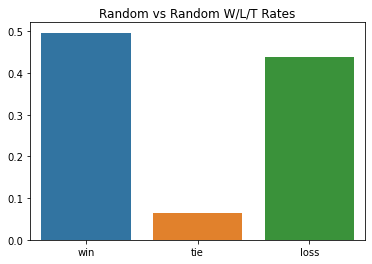

In [65]:
outcomes = [class_map[i] for i in classes]
fig = plt.figure()
ax = plt.axes()
sns.barplot(x=outcomes, y=rates)
ax.set_title('Random vs Random W/L/T Rates')
plt.show()

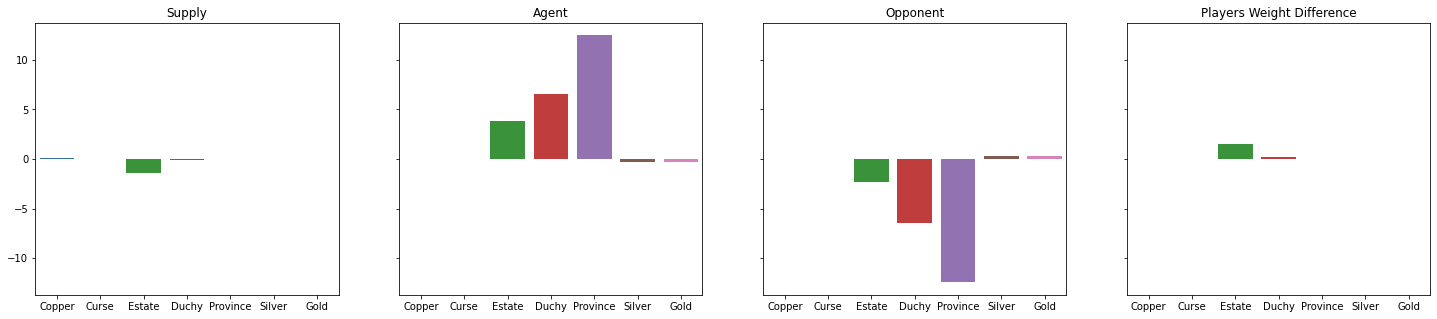

In [72]:
agent_weights = bm_terminal_model.coef_[0][7:14]
opp_weights = bm_terminal_model.coef_[0][14:]
supply_weights = bm_terminal_model.coef_[0][:7]
player_weight_diffs = agent_weights + opp_weights
cards = list(idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
axes[0].set_title('Supply')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
axes[1].set_title('Agent')
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
axes[2].set_title('Opponent')
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
axes[3].set_title('Players Weight Difference')
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])
plt.show()

Acc: 0.719
AUC ROC: 0.9710549579784873
F1 Score: 0.779261586802828
Threshold: 0.9999999, Acc: 0.916


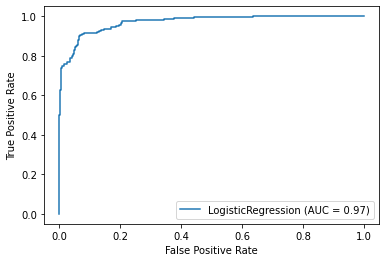

In [81]:
bm_terminal_test_probs = bm_terminal_model.predict_proba(test_X_random)[:, 1]
bm_terminal_pred = bm_terminal_model.predict(test_X_random)
print(f'Acc: {bm_terminal_model.score(test_X_random, test_y_random)}\nAUC ROC: {roc_auc_score(test_y_random, bm_terminal_test_probs)}\nF1 Score: {f1_score(test_y_random, bm_terminal_pred)}')
threshold = 0.9999999
bm_terminal_pred_thresholded = [1 if p > threshold else 0 for p in bm_terminal_test_probs]
print(f'Threshold: {threshold}, Acc: {sum(bm_terminal_pred_thresholded == test_y) / len(test_y)}')
plot_roc_curve(bm_terminal_model, test_X_random, test_y_random)
plt.show()

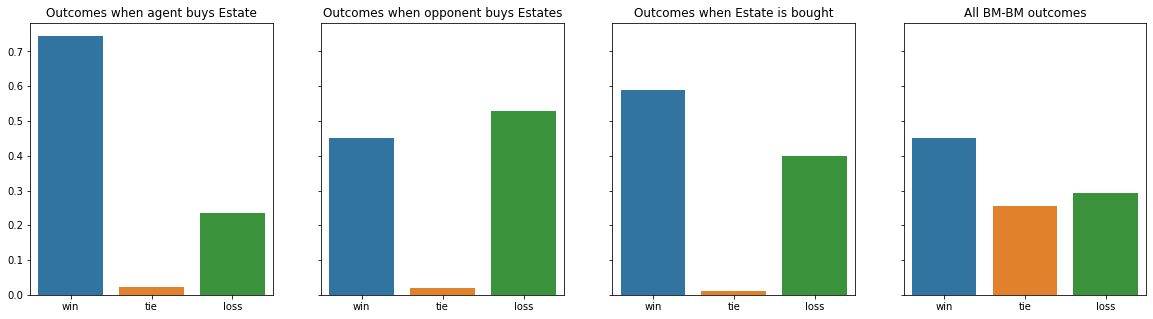

In [99]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey='all')

X_with_estates = list((i, x) for i, x in enumerate(X) if x[7+2] > 3)

X_with_estates_idxs = [i for i, x in X_with_estates]
y_with_estates = y[X_with_estates_idxs]

classes, rates = classification_rate(y_with_estates)

outcomes = [class_map[i] for i in classes]

sns.barplot(x=outcomes, y=rates, ax=ax[0])
ax[0].set_title('Outcomes when agent buys Estate')

X_with_estates = list((i, x) for i, x in enumerate(X) if x[14+2] > 3)

X_with_estates_idxs = [i for i, x in X_with_estates]
y_with_estates = y[X_with_estates_idxs]

classes, rates = classification_rate(y_with_estates)

outcomes = [class_map[i] for i in classes]
sns.barplot(x=outcomes, y=rates, ax=ax[1])
ax[1].set_title('Outcomes when opponent buys Estates')

X_with_estates = list((i, x) for i, x in enumerate(X) if x[2] <8)

X_with_estates_idxs = [i for i, x in X_with_estates]
y_with_estates = y[X_with_estates_idxs]

classes, rates = classification_rate(y_with_estates)

outcomes = [class_map[i] for i in classes]
sns.barplot(x=outcomes, y=rates, ax=ax[2])
ax[2].set_title('Outcomes when Estate is bought')

classes, rates = classification_rate(y)

outcomes = [class_map[i] for i in classes]
sns.barplot(x=outcomes, y=rates, ax=ax[3])
ax[3].set_title('All BM-BM outcomes')
plt.show()

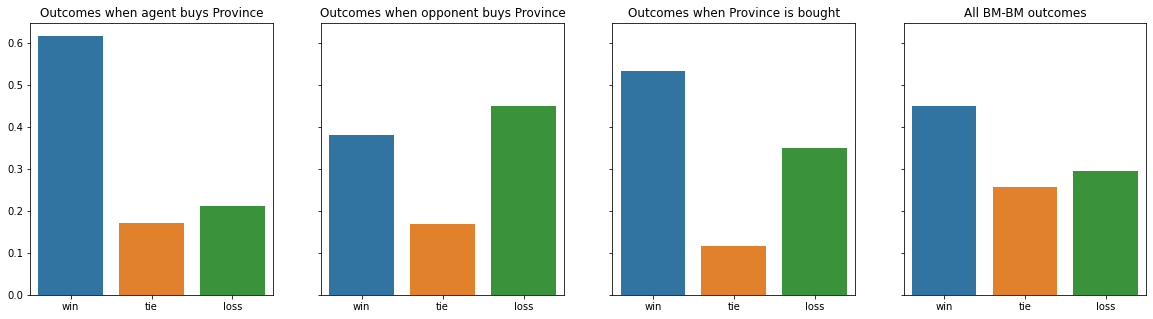

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey='all')

X_with_provinces = list((i, x) for i, x in enumerate(X) if x[7+3] > 0)

X_with_provinces_idxs = [i for i, x in X_with_provinces]
y_with_provinces = y[X_with_provinces_idxs]

classes, rates = classification_rate(y_with_provinces)

outcomes = [class_map[i] for i in classes]

sns.barplot(x=outcomes, y=rates, ax=ax[0])
ax[0].set_title('Outcomes when agent buys Duchy')

X_with_provinces = list((i, x) for i, x in enumerate(X) if x[14+3] > 0)

X_with_provinces_idxs = [i for i, x in X_with_provinces]
y_with_provinces = y[X_with_provinces_idxs]

classes, rates = classification_rate(y_with_provinces)

outcomes = [class_map[i] for i in classes]
sns.barplot(x=outcomes, y=rates, ax=ax[1])
ax[1].set_title('Outcomes when opponent buys Duchy')

X_with_provinces = list((i, x) for i, x in enumerate(X) if x[3] < 8)

X_with_provinces_idxs = [i for i, x in X_with_provinces]
y_with_provinces = y[X_with_provinces_idxs]

classes, rates = classification_rate(y_with_provinces)

outcomes = [class_map[i] for i in classes]
sns.barplot(x=outcomes, y=rates, ax=ax[2])
ax[2].set_title('Outcomes when Duchy is bought')

classes, rates = classification_rate(y)

outcomes = [class_map[i] for i in classes]
sns.barplot(x=outcomes, y=rates, ax=ax[3])
ax[3].set_title('All BM-BM outcomes')
plt.show()

## Random Players Predict BM Terminal State ##

In [ ]:
model_name = 'r-r-logistic-pred-10k-terminal'
model_path = os.path.join(model_dir, model_name)
r_terminal_model = load(model_path)

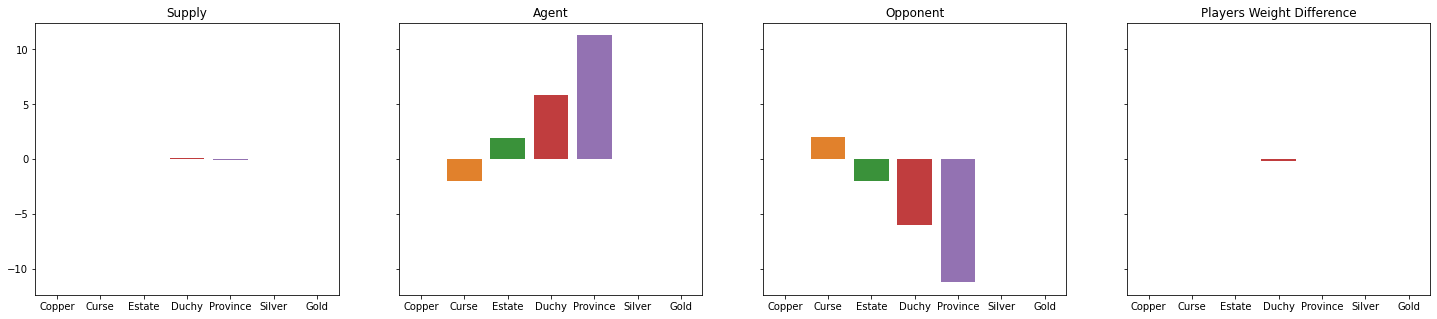

In [109]:
agent_weights = r_terminal_model.coef_[0][7:14]
opp_weights = r_terminal_model.coef_[0][14:]
supply_weights = r_terminal_model.coef_[0][:7]
player_weight_diffs = agent_weights + opp_weights
cards = list(idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
axes[0].set_title('Supply')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
axes[1].set_title('Agent')
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
axes[2].set_title('Opponent')
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
axes[3].set_title('Players Weight Difference')
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])
plt.show()

Acc: 0.822
AUC ROC: 0.9993414141414141
F1 Score: 0.8348794063079777
Threshold: 0.6, Acc: 0.99


<Figure size 432x288 with 0 Axes>

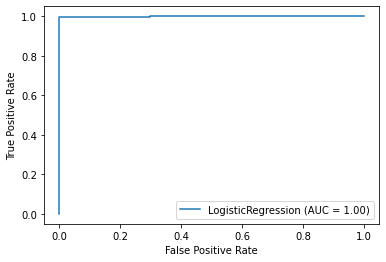

In [123]:
fig = plt.figure()
r_terminal_test_probs = r_terminal_model.predict_proba(test_X_bm)[:, 1]
r_terminal_pred = r_terminal_model.predict(test_X_bm)
print(f'Acc: {r_terminal_model.score(test_X_bm, test_y_bm)}\nAUC ROC: {roc_auc_score(test_y_bm, r_terminal_test_probs)}\nF1 Score: {f1_score(test_y_bm, r_terminal_pred)}')
plot_roc_curve(r_terminal_model, test_X_bm, test_y_bm)
threshold = 0.60
r_terminal_pred_thresholded = [1 if p > threshold else 0 for p in r_terminal_test_probs]
print(f'Threshold: {threshold}, Acc: {sum(r_terminal_pred_thresholded == test_y_bm) / len(test_y_bm)}')
plt.show()

## Effects of Regularization ##

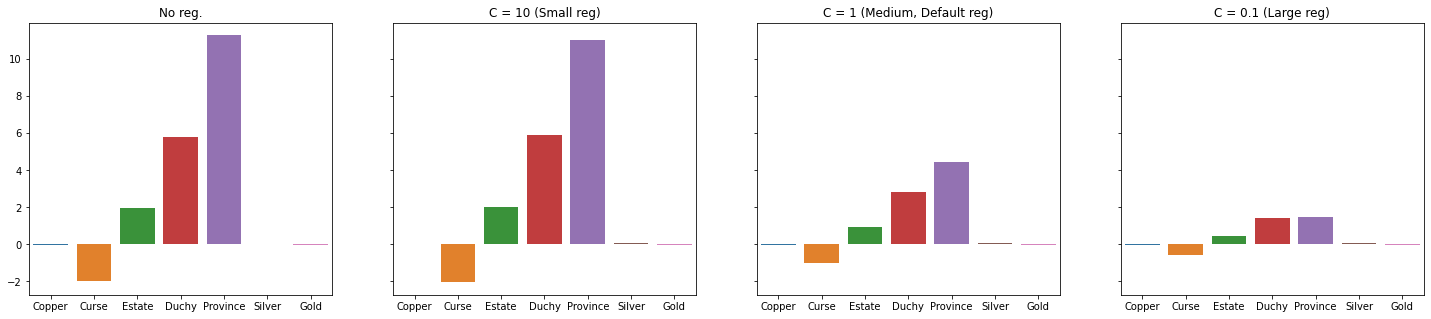

In [125]:
model_name = 'r-r-logistic-pred-10k-terminal'
model_path = os.path.join(model_dir, model_name)
r_model_nopenalty = load(model_path)

model_name = 'r-r-logistic-pred-1k-terminal-C-1e-1'
model_path = os.path.join(model_dir, model_name)
r_model_largep = load(model_path)

model_name = 'r-r-logistic-pred-1k-terminal-C-1'
model_path = os.path.join(model_dir, model_name)
r_model_medp = load(model_path)

model_name = 'r-r-logistic-pred-1k-terminal-C-10'
model_path = os.path.join(model_dir, model_name)
r_model_smallp = load(model_path)

nop_weights = r_model_nopenalty.coef_[0][7:14]
smallp_weights = r_model_smallp.coef_[0][7:14]
medp_weights = r_model_medp.coef_[0][7:14]
largep_weights = r_model_largep.coef_[0][7:14]
cards = list(idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
axes[0].set_title('No reg.')
sns.barplot(x=cards, y=nop_weights, ax=axes[0])
axes[1].set_title('C = 10 (Small reg)')
sns.barplot(x=cards, y=smallp_weights, ax=axes[1])
axes[2].set_title('C = 1 (Medium, Default reg)')
sns.barplot(x=cards, y=medp_weights, ax=axes[2])
axes[3].set_title('C = 0.1 (Large reg)')
sns.barplot(x=cards, y=largep_weights, ax=axes[3])
plt.show()

## Can logistic learn to buy money? ##

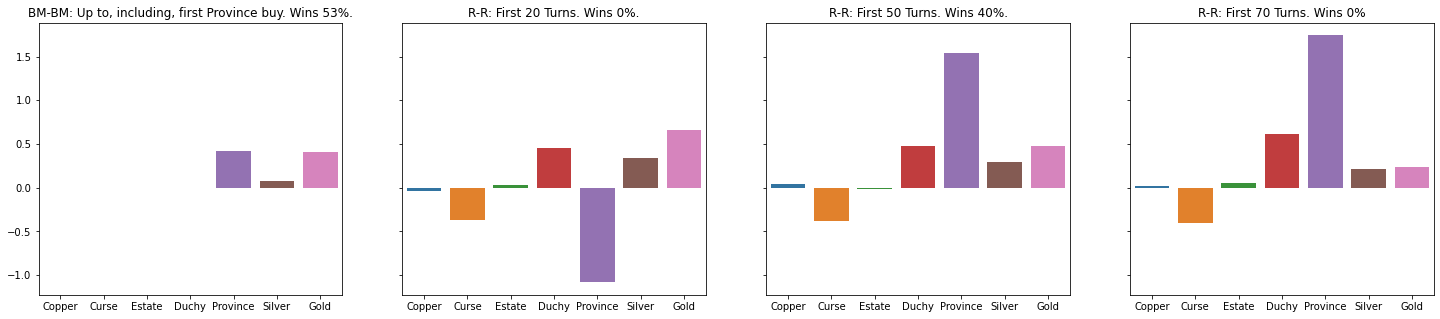

In [128]:
model_name = 'bm-bm-logistic-pred-1k-first-province'
model_path = os.path.join(model_dir, model_name)
bm_first_province = load(model_path)

model_name = 'r-r-logistic-pred-1k-20'
model_path = os.path.join(model_dir, model_name)
r_20 = load(model_path)

model_name = 'r-r-logistic-pred-1k-50'
model_path = os.path.join(model_dir, model_name)
r_50 = load(model_path)

model_name = 'r-r-logistic-pred-1k-70'
model_path = os.path.join(model_dir, model_name)
r_70 = load(model_path)

bm_first_province_weights = bm_first_province.coef_[0][7:14]
r_20_weights = r_20.coef_[0][7:14]
r_50_weights = r_50.coef_[0][7:14]
r_70_weights = r_70.coef_[0][7:14]
cards = list(idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
axes[0].set_title('BM-BM: Up to, including, first Province buy. Wins 53%.')
sns.barplot(x=cards, y=bm_first_province_weights, ax=axes[0])
axes[1].set_title('R-R: First 20 Turns. Wins 0%.')
sns.barplot(x=cards, y=r_20_weights, ax=axes[1])
axes[2].set_title('R-R: First 50 Turns. Wins 40%.')
sns.barplot(x=cards, y=r_50_weights, ax=axes[2])
axes[3].set_title('R-R: First 70 Turns. Wins 0%')
sns.barplot(x=cards, y=r_70_weights, ax=axes[3])
plt.show()

## Human/BM Performance ##

**When starting first, I went 5/4/1 W/L/T. When starting second, 6/2/2 W/L/T.**

## Best performance so far... ##
**Idea: MCTS with greedy logistic regression rollouts, maintaining one logreg model for each number of remaining provinces (7) total. Warm-start the rollout training by setting model 8 equal to the model trained on BM-BM data up to the first Province. Simultaneously grow the tree and use the trajectories to train the logreg models.**

**Preliminary results: Can achieve W/L/T of 65/21/14 when starting and 69/30/1 when following.**